In [37]:
from __future__ import absolute_import, division, print_function

import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Dense, Flatten, Dropout, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras import layers
from keras.models import Sequential,load_model
from keras import backend as K
from keras.callbacks import *
from keras.initializers import glorot_normal
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

import numpy as np
from scipy import fftpack
from scipy import ndimage

from IPython.display import clear_output
from matplotlib import pyplot as plt

import cv2

import pickle
import os.path
import sys
import zipfile

sys.path.append('..')
from defectfinder import gridsearch

In [2]:
gridsearch.detectGPU()

----Available GPUs(if GPU is detected, the code will automatically run on GPU)----
[]
----Devices imformation----
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8873659319017601450
]


In [41]:
# unzip the dataset and load
zip_ref=zipfile.ZipFile("../dataset/dataset.zip",'r')
zip_ref.extractall("..")
zip_ref.close()

x_train_origin=np.load("../dataset/x_train.npy")
x_test_origin=np.load("../dataset/x_test.npy")
y_train_origin=np.load("../dataset/y_train.npy")
y_test_origin=np.load("../dataset/y_test.npy")

In [4]:
# make it center to 0, and the standarddeviation is 1
x_train=(x_train_origin-np.mean(x_train_origin))/np.std(x_train_origin)
x_test=(x_test_origin-np.mean(x_train_origin))/np.std(x_train_origin)

## Test the model
* At first we use only a small amount of data to test the model. The accuracy of a good model is expected to be 1.00 (Though the validation accuracy maybe very low)

In [7]:
num_classes = 6

# input image dimensions
img_x, img_y = 64, 64
input_shape = (img_x, img_y, 1)

In [12]:
#At beginning only use very few training data
x_train_sample,y_train_sample=resample(x_train_origin,y_train_origin,n_samples=60,replace=False)
x_test_sample,y_test_sample=resample(x_test_origin,y_test_origin,n_samples=20,replace=False)

x_train_sample=(x_train_sample-np.mean(x_train_sample))/np.std(x_train_sample)
x_test_sample=(x_test_sample-np.mean(x_train_sample))/np.std(x_train_sample)

* May need to upgrade to the latest version of tensorflow when use "get_model()"

In [14]:
model=gridsearch.get_model(0.01) #learning rate=0.01

In [14]:
plot = gridsearch.PlotLearning()

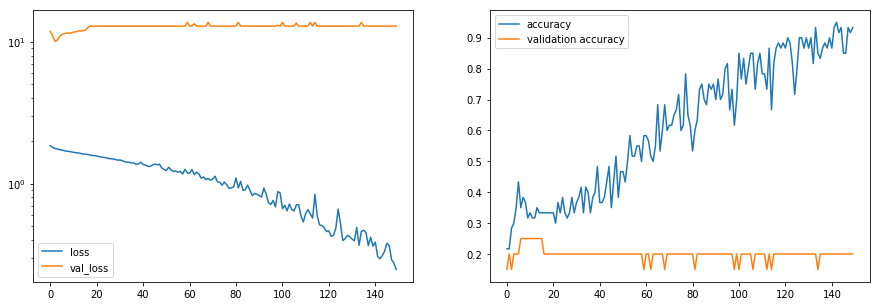

In [15]:
model.fit(x_train_sample,y_train_sample,
         batch_size=16,
         epochs=150,
         verbose=1,
         validation_data=(x_test_sample,y_test_sample),
         callbacks=[plot])

## Grid Search
* Randomly search learning rate from 1e-5 to 1

In [5]:
np.random.seed(304)

learn_rate=(10**np.random.uniform(-5,0,15)).tolist() 
# this the list of learning rate you want to search

batch_size=128
epochs=150

In [7]:
# models is a list of models with learning rate from the search list
# result is a list of training history

result,models=gridsearch.gridsearch(x_train,y_train_origin,[0.01,0.02],batch_size,1)

Train on 27403 samples, validate on 13497 samples
Epoch 1/1
27403/27403 [==============================] - 78s 3ms/step - loss: 1.5991 - acc: 0.3109 - val_loss: 2.0298 - val_acc: 0.3802
Train on 27403 samples, validate on 13497 samples
Epoch 1/1
27403/27403 [==============================] - 73s 3ms/step - loss: 1.4357 - acc: 0.4103 - val_loss: 1.4521 - val_acc: 0.5236


In [17]:
# load previous search result

load_res=gridsearch.load_results(learn_rate,"../HyperparametersTuning/learn_rate")

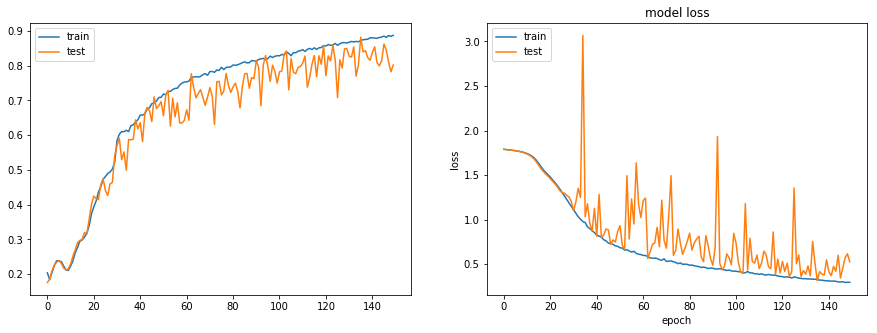

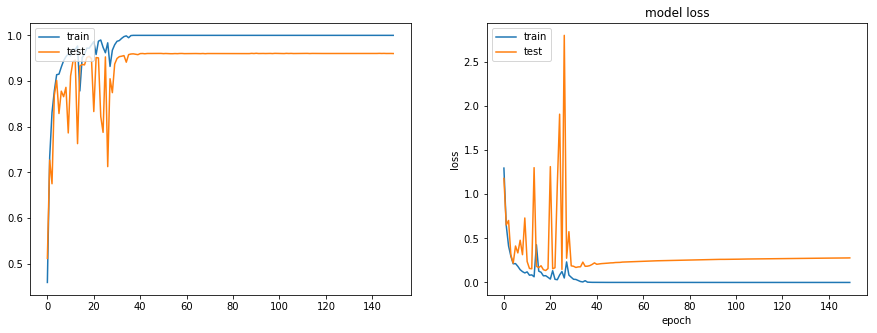

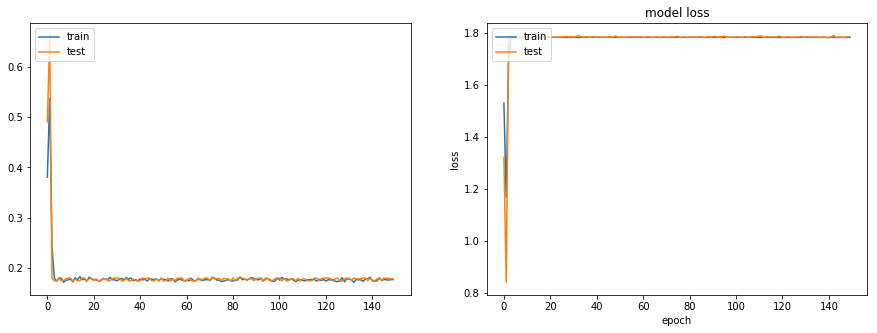

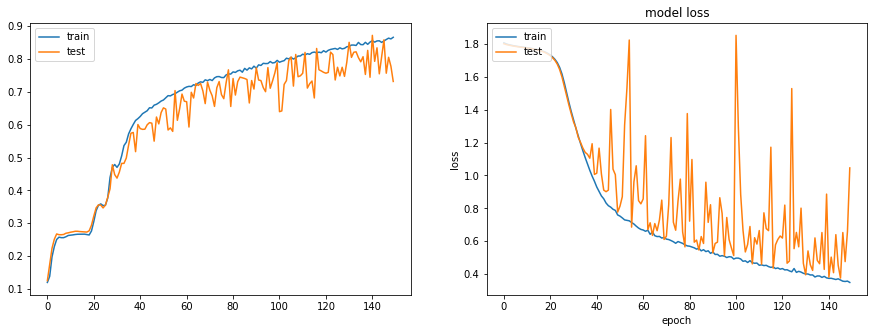

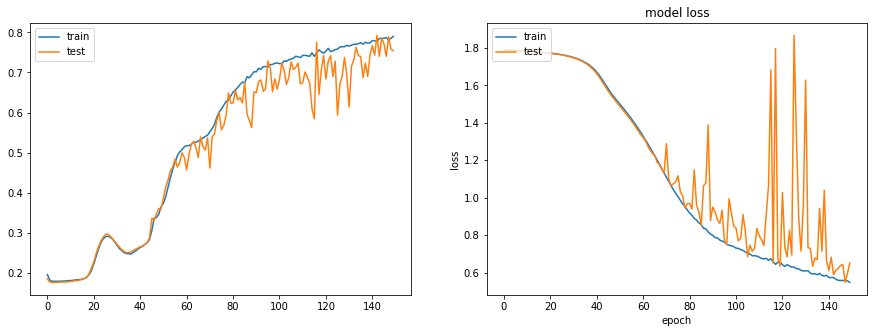

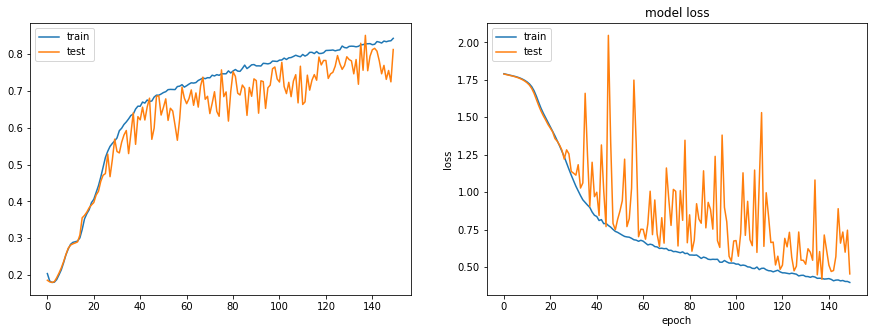

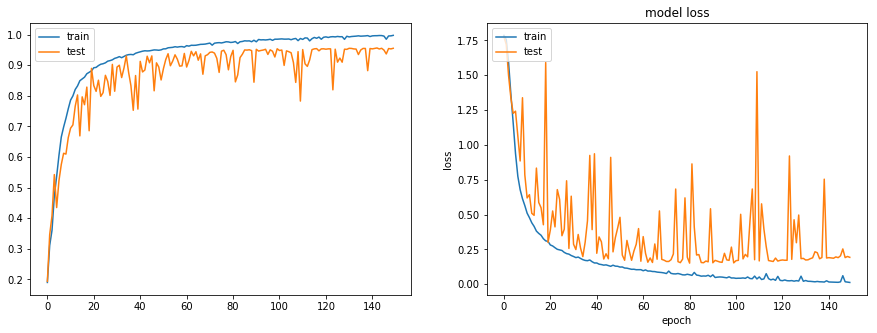

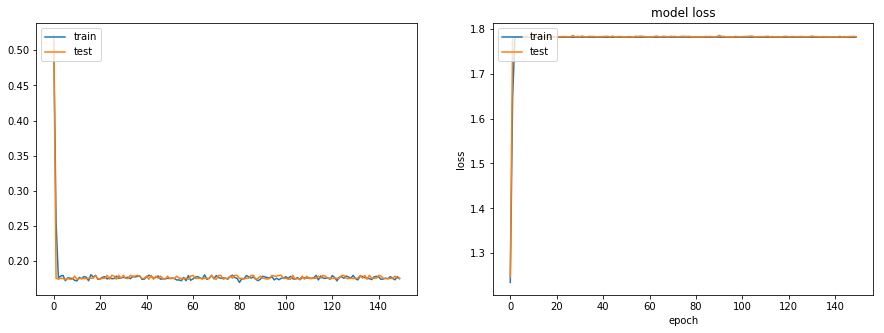

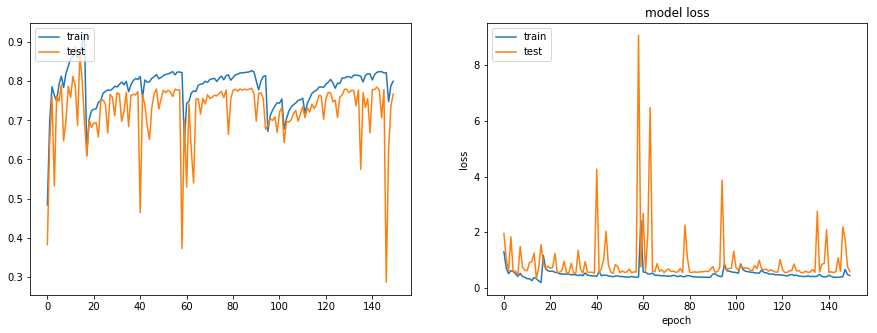

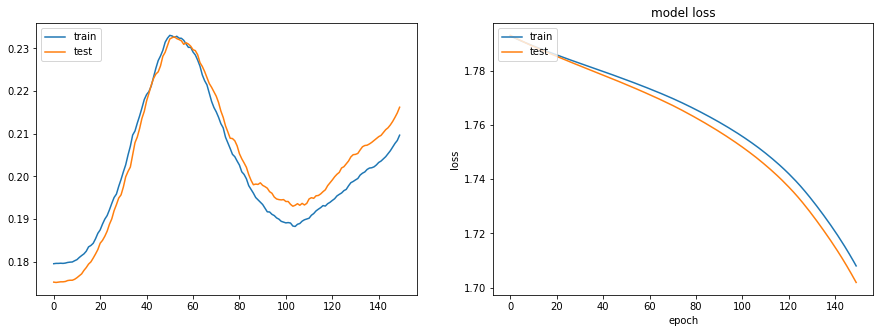

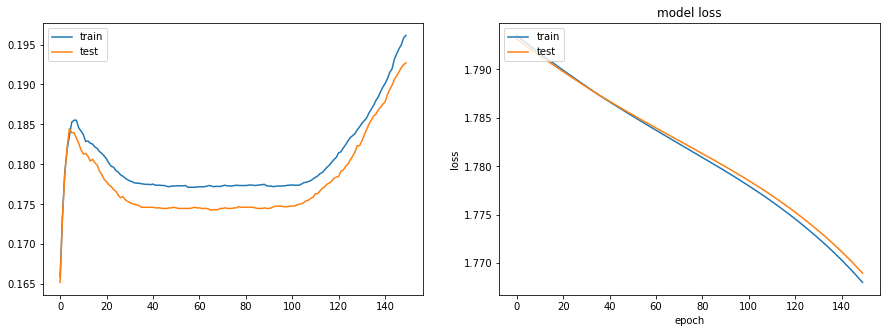

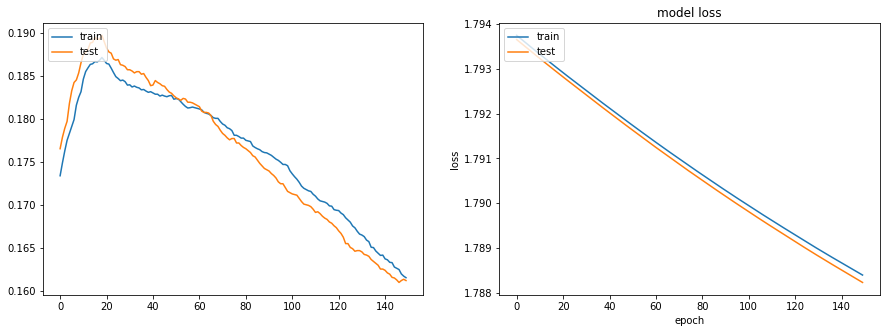

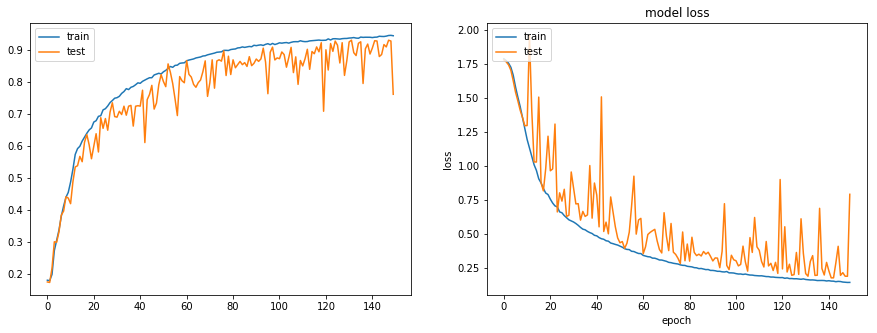

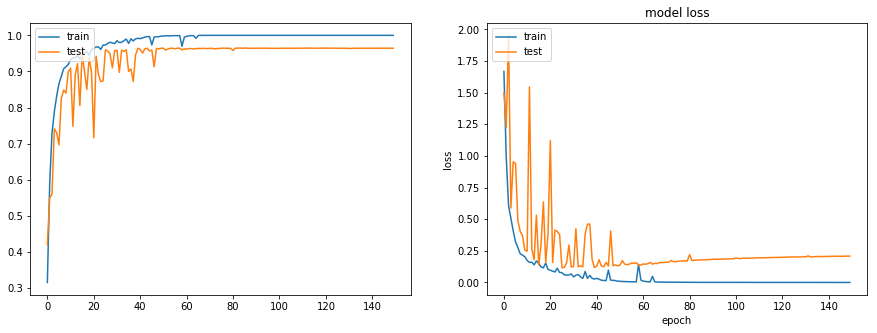

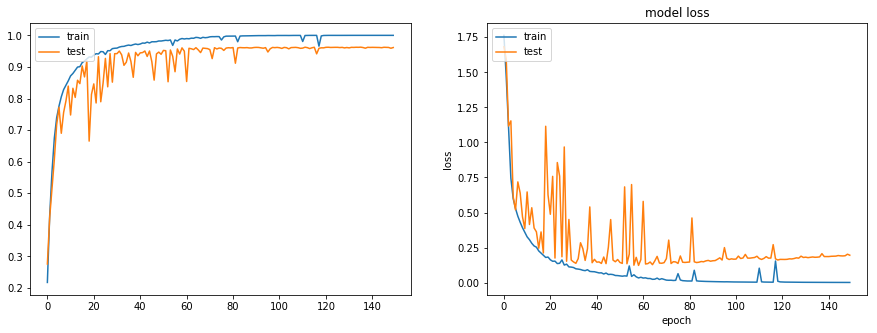

In [13]:
# plot accuracy, validation accuracy, loss and validation loss for each model.

for j in range(len(learn_rate)):
    history=load_res[j]

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5),sharex=True)
    ax1.plot(history['acc'])
    ax1.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')

    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()



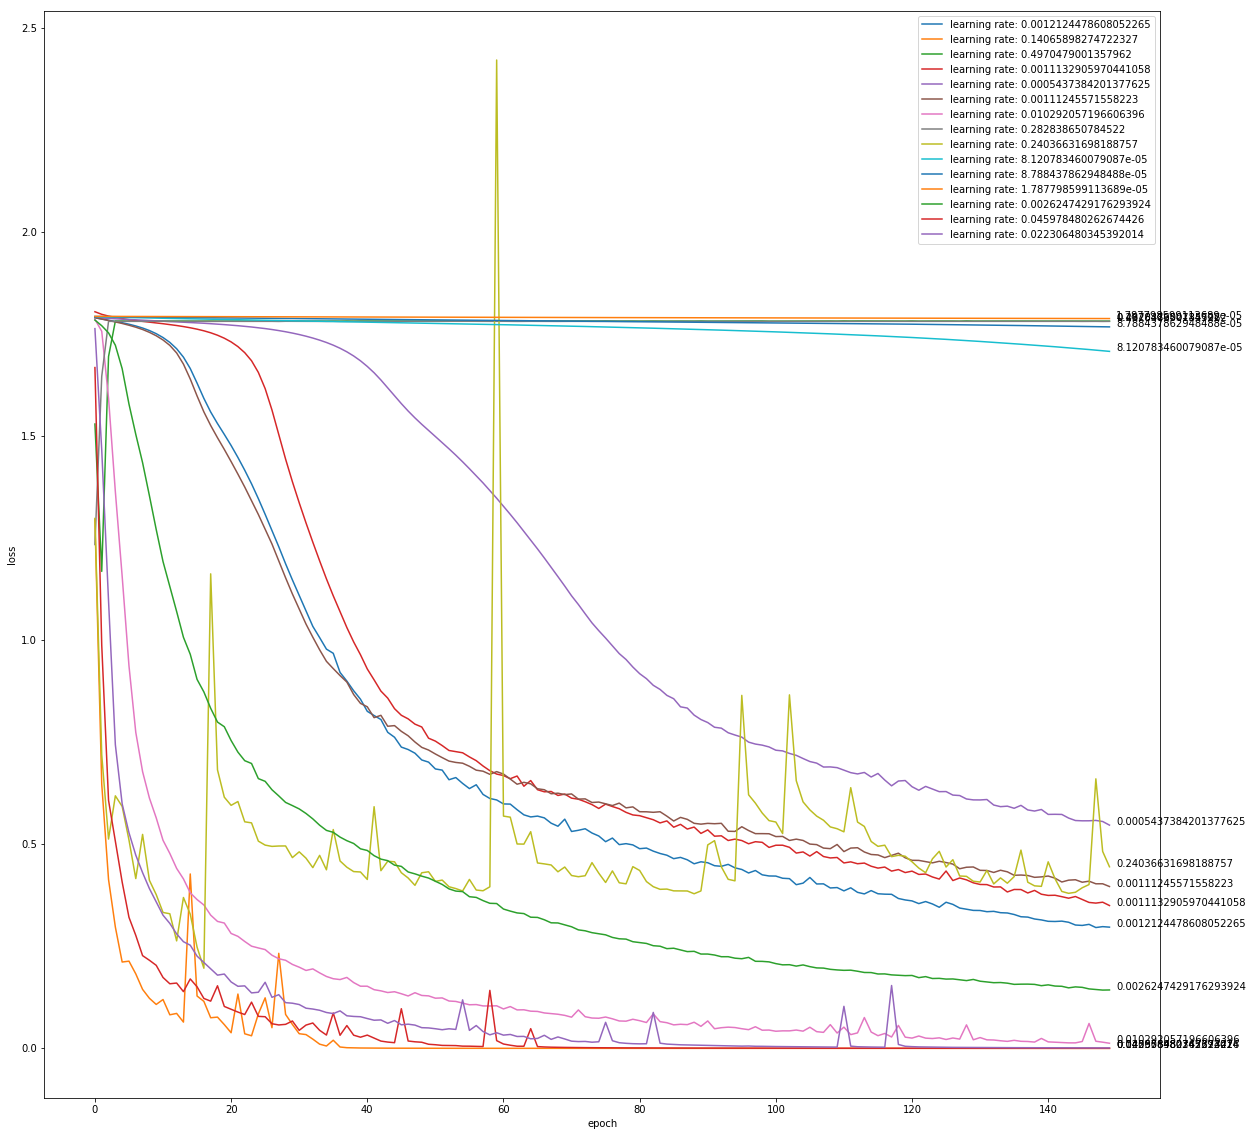

In [88]:
#plot the loss for each model
plt.figure(figsize=(20,20))

for j in range(len(learn_rate)):
    plt.plot(load_res[j]['loss'],label="learning rate: "+str(learn_rate[j]))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.text(150,load_res[j]['loss'][149],str(learn_rate[j]))
    
plt.legend()

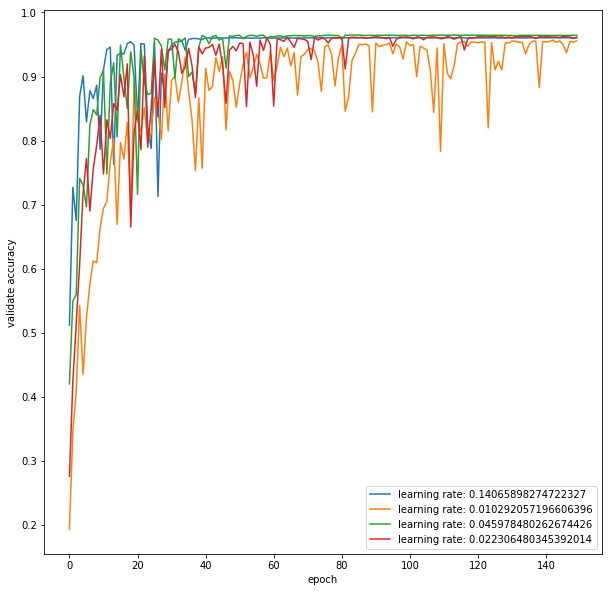

In [89]:
#plot validation accuracy for each model

plt.figure(figsize=(10,10))

for j in range(len(learn_rate)):
    if(learn_rate[j]>0.01 and learn_rate[j]<0.2):
        plt.plot(load_res[j]['val_acc'],label="learning rate: "+str(learn_rate[j]))
        plt.xlabel("epoch")
        plt.ylabel("validate accuracy")
    
plt.legend()

In [101]:
#get the test accuracy of a selected model
select_model=load_model("./learn_rate/model1.h5")

scores=select_model.evaluate(x_test,y_test_origin,verbose=1)

print("%s: %.2f%%" % (select_model.metrics_names[1], scores[1]*100))

10225/10225 [==============================] - 10s 973us/step
acc: 96.57%


## Class Activation Map

In [153]:
def visualize_class_activation_map(model_path, img_path, output_path):
    #model = load_model(model_path)
    model=model_path
    #original_img = img_to_array(load_img(img_path, grayscale = True))
    original_img=img_path
    width, height, _ = original_img.shape

    #Reshape to the network input shape (3, w, h).
    #img = np.array([np.transpose(np.float32(original_img), (0, 1,2))])
    img = np.array([np.transpose(np.float32(original_img), (0, 1,2))])
        
    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-2].get_weights()[0]
    #final_conv_layer = get_output_layer(model, "conv5_3")
    final_conv_layer = model.layers[10]   #because final convolutional layer is the 7th layer
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    imglist=[]
    imglist.append(img)
    [conv_outputs, predictions] = get_output(imglist)
    conv_outputs = conv_outputs[0, :, :, :]

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    target_class = 0
    for i, w in enumerate(class_weights[:,target_class]):
        cam += w * conv_outputs[:, :, i] # i th channel * w_i
    print(predictions)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
    #heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap=np.uint8(255*cam)
    heatmap[np.where(cam < 0.2)] = 0
    #original= cv2.applyColorMap(np.uint8(255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img))), 
                                         #cv2.COLORMAP_BONE)
    original=255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img))
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.reshape(original_img,(64,64)),cmap = 'gray')
    ax1.set_title('Original image')
    #ax2.imshow(heatmap)
    ax2.imshow(heatmap, cmap = 'jet')
    ax2.imshow(np.reshape(original,(64,64)), cmap = 'gray', alpha = 0.5)
    #ax2.set_title('Original image + CAM \n Class: ' + defect_type)

    #print('defect type:', defect_type)
    #img = original_img
    #cv2.imwrite(output_path, img)

In [151]:
original_img=x_test_origin[2]
np.std(255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img)))

114.40049

[[1.1357773e-34 5.9855844e-12 0.0000000e+00 8.4586991e-25 1.0000000e+00
  0.0000000e+00]]
[[4.3402495e-26 9.4396368e-10 0.0000000e+00 1.3510901e-21 1.0000000e+00
  1.3039374e-30]]
[[1.6729265e-33 5.5652949e-13 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00]]
[[7.932011e-32 5.150086e-11 0.000000e+00 0.000000e+00 1.000000e+00
  6.164912e-31]]


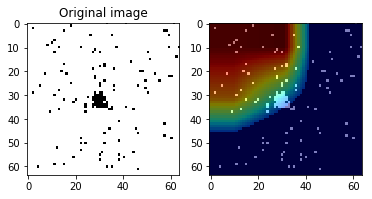

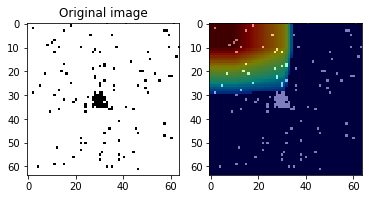

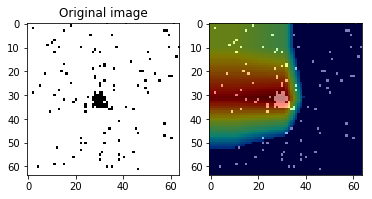

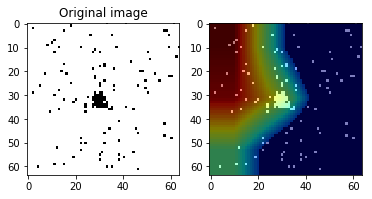

In [155]:
models_grid=[]

for j in range(len(learn_rate)):
    if(learn_rate[j]>0.01 and learn_rate[j]<0.2):
        models_grid.append(load_model('./learn_rate/model'+str(j)+'.h5'))
        visualize_class_activation_map(models_grid[-1], x_test_origin[0],
                                       "./heatmap/"+str(learn_rate[j])+".png")

In [13]:
learn_rate

[0.0012124478608052265,
 0.14065898274722327,
 0.4970479001357962,
 0.0011132905970441058,
 0.0005437384201377625,
 0.00111245571558223,
 0.010292057196606396,
 0.282838650784522,
 0.24036631698188757,
 8.120783460079087e-05,
 8.788437862948488e-05,
 1.787798599113689e-05,
 0.0026247429176293924,
 0.045978480262674426,
 0.022306480345392014]

In [27]:
for i in range(len(model.layers)):
    j=len(model.layers)-i-1
    if "activation_4" in model.layers[j].get_config()['name']:
        final_conv_layer=model.layers[j]
        print(j)
        break
    

10


## Prediction Validation

In [15]:
# load the experimental data
expdata=np.load("defect_list10.npy")

In [153]:
#expdata=expdata.reshape(expdata.shape[0],img_x,img_y,1)

In [16]:
#imgsrc=expdata[0]
imgsrc=x_test[2].reshape(64,64)


# 1/ratio of the radius of the mask to the original image in pixels
maskratio = 10

def FFTmask(imgsrc, maskratio=10):
    """Takes a square real space image and filter out a disk with radius equal to:
    1/maskratio * image size.
    Retruns FFT transform of the image and the filtered FFT transform
    """
    # Take the fourier transform of the image.
    F1 = fftpack.fft2((imgsrc)) 
    # Now shift so that low spatial frequencies are in the center.
    F2 = (fftpack.fftshift((F1)))
    # copy the array and zero out the center
    F3 = F2.copy()
    l = int(imgsrc.shape[0]/maskratio)
    m = int(imgsrc.shape[0]/2)
    y,x = np.ogrid[1: 2*l + 1, 1:2*l + 1]
    mask = (x - l)*(x - l) + (y - l)*(y - l) <= l*l
    F3[m-l:m+l, m-l:m+l] = F3[m-l:m+l, m-l:m+l] * (1 - mask)
    
    return F2, F3

F2, F3 = FFTmask(imgsrc, maskratio)

In [17]:
def FFTsub(imgsrc, F3):
    """Takes real space image and filtred FFT.
    Reconstructs real space image and subtracts it from the original.
    Returns normalized image. 
    """
    reconstruction = np.real(fftpack.ifft2(fftpack.ifftshift(F3)))
    diff = np.abs(imgsrc - reconstruction)
    
    #normalization
    diff = diff - np.amin(diff)
    diff = diff/np.amax(diff)
    
    return diff

In [18]:
diff = FFTsub(imgsrc, F3)
diff.shape

(64, 64)

In [19]:
def threshImg(diff, threshL=0.25, threshH=0.75):
    """Takes in difference image, low and high thresold values, and outputs a map of all defects.
    """
    
    threshIL = diff < threshL  
    threshIH = diff > threshH
    threshI = threshIL + threshIH
    
    return threshI

In [20]:
threshL = 0.25
threshH = 0.75

(-0.5, 63.5, 63.5, -0.5)

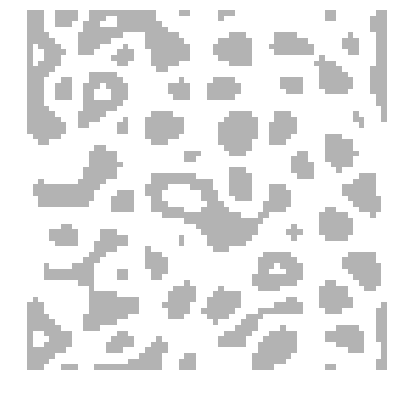

In [24]:
fig104 = plt.figure(104, figsize=(5,5))
ax = fig104.add_axes([0, 0, 1, 1])

threshI = threshImg(diff, threshL, threshH)

#ax.imshow(imgsrc)
#ax.imshow(threshI, cmap='coolwarm', alpha=0.3)
ax.imshow(threshI,cmap="gray", alpha=0.3)
ax.axis('off')